In [2]:
import pooch
import xlandsat as xls
import numpy as np
import pandas as pd
import xarray as xr
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cluster
import seaborn as sns
import matplotlib.pyplot as plt

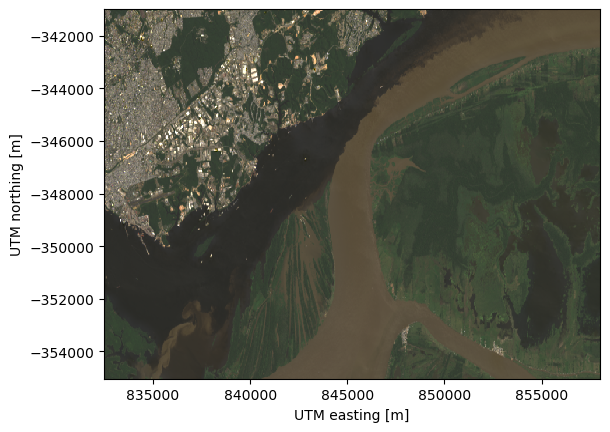

In [3]:
# path_l1 = xls.datasets.fetch_momotombo(level=1)
# scene = xls.load_scene(path_l1)
# path_l2 = xls.datasets.fetch_momotombo(level=2)
# scene = scene.merge(xls.load_scene(path_l2, bands=["thermal"]))
scene = xls.load_scene(xls.datasets.fetch_manaus())
# scene = xls.load_scene(
#     pooch.retrieve(
#         "doi:10.6084/m9.figshare.21930384.v2/LC08_L2SP_042036_20180126_20200902_02_T1-cropped.tar.gz", 
#         known_hash="md5:be8509daf433918e5279ffe01649281f",
#     ),
#     bands="blue green red nir swir1 swir2".split(),
# )
# scene = xls.interpolate_missing(scene, method="nn")
xls.composite(scene, rescale_to=(0, 0.3)).plot.imshow()

In [4]:
def _scene_to_dataframe(scene, bands=None):
    if bands is None:
        bands = list(scene)
    data = pd.DataFrame(
        {band: scene[band].values.ravel() for band in bands}
    )
    return data

def _scene_to_features(scene, bands=None):
    if bands is None:
        bands = list(scene)
    data = np.transpose(
        [scene[band].values.ravel() for band in bands]
    )
    return data

def _scene_shape(scene):
    shapes = [scene[b].shape for b in scene]
    if not all(shape == shapes[0] for shape in shapes):
        raise ValueError(s
            f"All variables of a scene must have the same shape. Found shapes: {shapes}"
        )
    return shapes[0]

def _scene_dims(scene):
    dims = [scene[b].dims for b in scene]
    if not all(dim == dims[0] for dim in dims):
        raise ValueError(
            f"All dimensions of a scene must have the same. Found dims: {dims}"
        )
    return dims[0]
    
def _add_processing_to_attrs(scene, description):
    attrs = dict(scene.attrs)
    if "processing" not in attrs:
        attrs["processing"] = []
    attrs["processing"].append(description)
    return attrs

In [5]:
def scale(scene, robust=True, **kwargs):
    data = _scene_to_features(scene)
    if robust:
        scaler = sklearn.preprocessing.RobustScaler(**kwargs)
    else:
        scaler = sklearn.preprocessing.StandardScaler(**kwargs)
    scaled = scaler.fit_transform(data).T
    attrs = _add_processing_to_attrs(scene, "Scaled with sklearn.preprocessing.StandardScaler")
    dims = _scene_dims(scene)
    shape = _scene_shape(scene)
    scaled_scene = xr.Dataset(
        {
            band_name: (dims, band.reshape(shape), scene[band_name].attrs) 
            for band_name, band in zip(scene, scaled)
        },
        coords=scene.coords,
        attrs=attrs,
    )
    return scaled_scene

def pairplot(scene, **kwargs):
    return sns.pairplot(_scene_to_dataframe(scene), **kwargs)    

def pca(scene, **kwargs):
    data = _scene_to_features(scene)
    pca = sklearn.decomposition.PCA(**kwargs).fit(data)
    pca_bands = pca.transform(data).T
    attrs = _add_processing_to_attrs(scene, "Decomposition with sklearn.decomposition.PCA")
    attrs["explained_variance_ratio"] = pca.explained_variance_ratio_
    attrs["explained_variance"] = pca.explained_variance_
    dims = _scene_dims(scene)
    shape = _scene_shape(scene)
    scene_pca = xr.Dataset(
        {
            f"PCA{i}": (
                dims, 
                band.reshape(shape), 
                {"explained_variance_ratio": variance},
            ) 
            for i, (band, variance) in enumerate(zip(pca_bands, pca.explained_variance_ratio_))
        },
        coords=scene.coords,
        attrs=attrs,
    )
    return scene_pca

def ica(scene, **kwargs):
    data = _scene_to_features(scene)
    ica = sklearn.decomposition.FastICA(**kwargs).fit(data)
    ica_bands = ica.transform(data).T
    attrs = _add_processing_to_attrs(scene, "Decomposition with sklearn.decomposition.FastICA")
    dims = _scene_dims(scene)
    shape = _scene_shape(scene)
    scene_ica = xr.Dataset(
        {
            f"ICA{i}": (
                dims, 
                band.reshape(shape), 
            ) 
            for i, band in enumerate(ica_bands)
        },
        coords=scene.coords,
        attrs=attrs,
    )
    return scene_ica

def cluster(scene, n_clusters, bands=None, **kwargs):
    data = _scene_to_features(scene, bands=bands)
    clustering = sklearn.cluster.KMeans(n_clusters=n_clusters, **kwargs)
    labels = clustering.fit(data).predict(data)
    dims = _scene_dims(scene)
    shape = _scene_shape(scene)
    clusters = xr.DataArray(
        labels.reshape(shape), 
        dims=dims, 
        coords=scene.coords,
        name="clusters",
    )
    return clusters
    
def plot_cluster_spectrum(scene, clusters, bands=None, ax=None, cmap=None):
    if bands is None:
        bands = list(scene)
    if ax is None:
        ax = plt.gca()
    features = _scene_to_dataframe(scene, bands=bands).assign(**{clusters.name: clusters.values.ravel()})
    labels = features[clusters.name].unique()
    if cmap is None:
        cmap = plt.get_cmap("Accent", labels.size)
    elif isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap, labels.size)
    features.groupby(clusters.name).median()[bands].T.plot(
        ax=ax,
        color=cmap(sorted(features[clusters.name].unique()))
    )

def quantile_filter(scene, quantile_range=(0.05, 0.95)):
    bands = []
    for b in scene:
        band = scene[b].values
        vmin, vmax = np.quantile(band, quantile_range)
        band[band > vmax] = vmax
        band[band < vmin] = vmin
        bands.append(band)
    attrs = _add_processing_to_attrs(scene, f"Cropped to the quantile range {quantile_range}")
    dims = _scene_dims(scene)
    result = xr.Dataset(
        {
            band_name: (dims, band, scene[band_name].attrs) 
            for band_name, band in zip(scene, bands)
        },
        coords=scene.coords,
        attrs=attrs,
    )
    return result
    

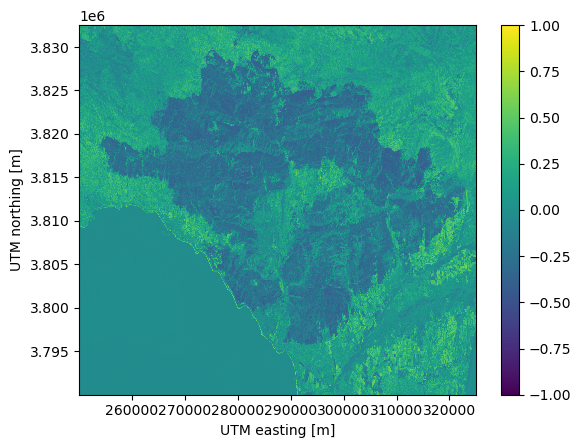

In [34]:
ndvi = (scene.nir - scene.red)/(scene.nir + scene.red)
nbr = (scene.nir - scene.swir2)/(scene.nir + scene.swir2)
ndwi = (scene.green - scene.nir)/(scene.green + scene.nir)
nbr.plot(vmin=-1, vmax=1)

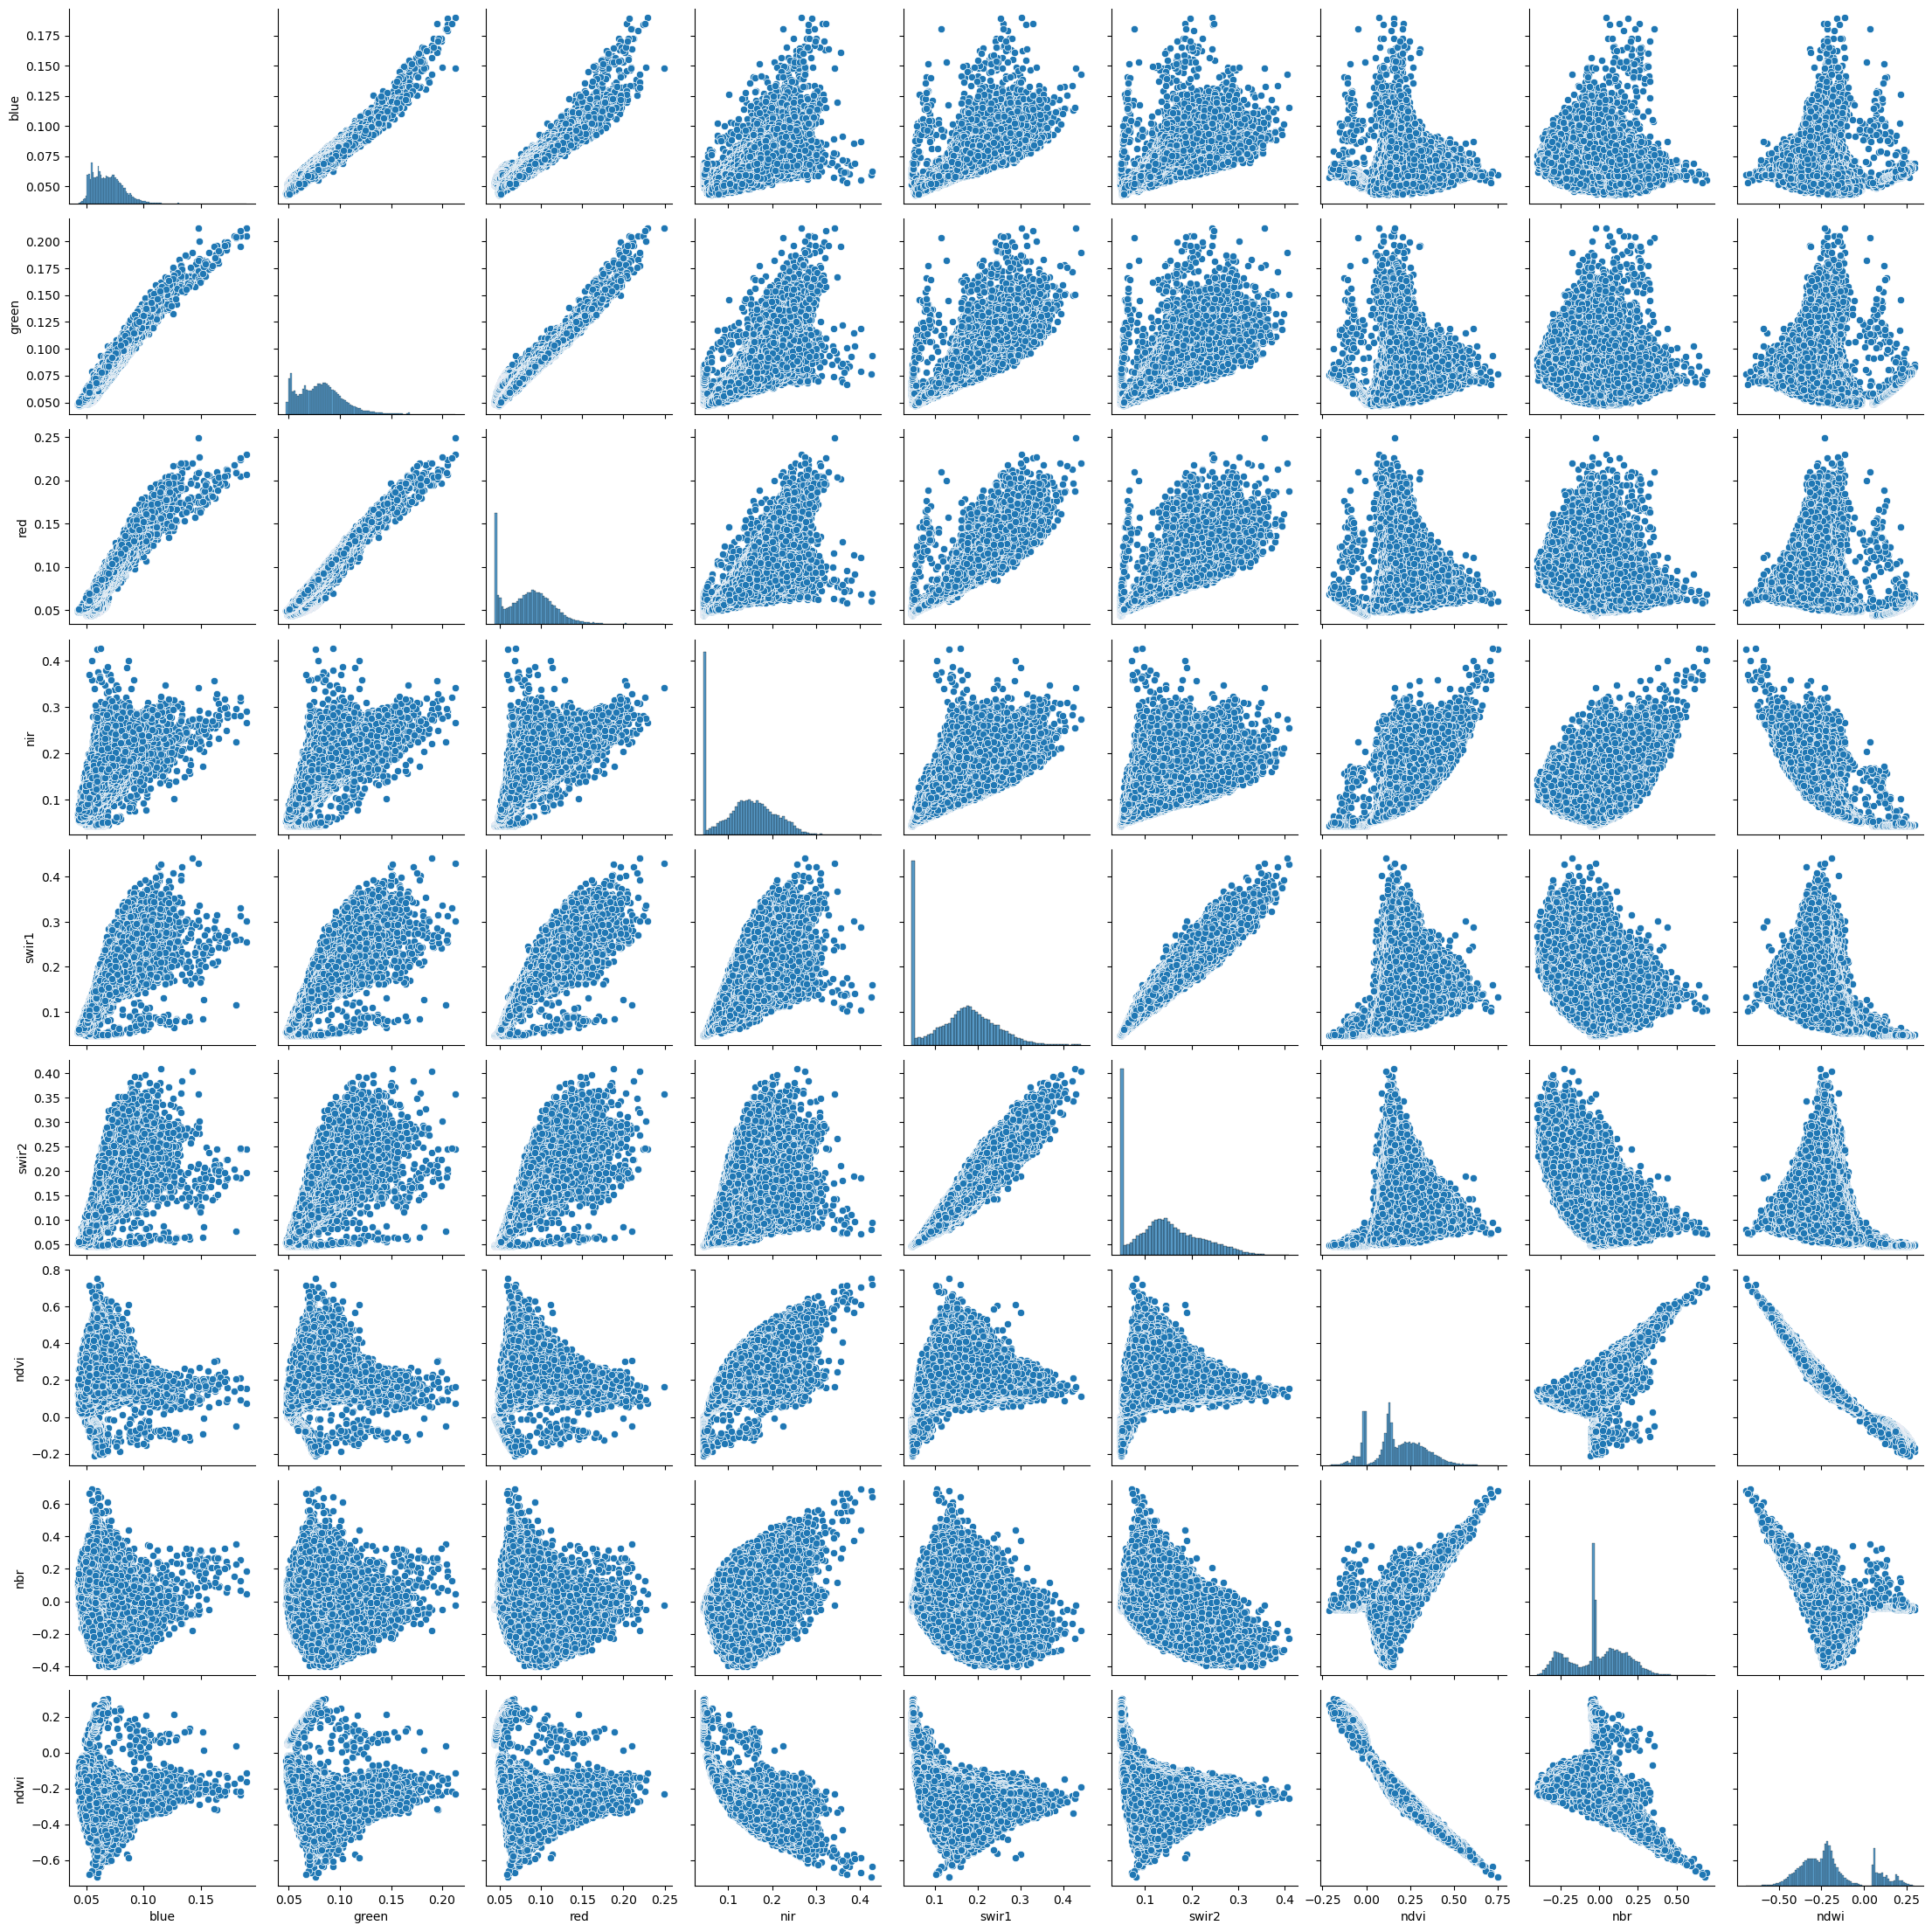

In [6]:
pairplot(scene.assign(ndvi=ndvi, nbr=nbr, ndwi=ndwi).coarsen(easting=10, northing=10, boundary="trim").median()) 

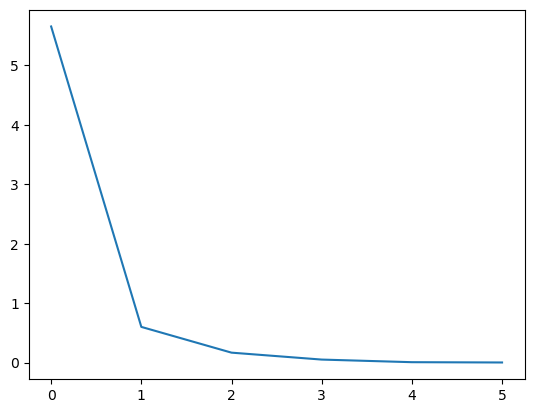

In [39]:
n = None
# meh = scale(quantile_filter(xr.Dataset(dict(ndvi=ndvi, nbr=nbr, ndwi=ndwi))))
scene_pca = pca(scale(scene), n_components=n)
scene_ica = ica(scene_pca, random_state=0)
clusters = cluster(scale(scene), n_clusters=5, random_state=0)
plt.plot(scene_pca.attrs["explained_variance"])

In [47]:
features = _scene_to_dataframe(scene).assign(**{clusters.name: clusters.values.ravel()})
features

blue     green       red       nir     swir1     swir2  clusters
0       0.059082  0.074463  0.061523  0.291504  0.141113  0.079956         0
1       0.058960  0.075195  0.062012  0.292969  0.143433  0.080933         0
2       0.059326  0.076538  0.062866  0.295410  0.147705  0.083618         0
3       0.058838  0.074219  0.062134  0.267090  0.134766  0.078979         0
4       0.059082  0.072876  0.062378  0.258789  0.127563  0.076416         0
...          ...       ...       ...       ...       ...       ...       ...
398263  0.066772  0.090698  0.104614  0.063965  0.050659  0.049438         4
398264  0.067749  0.092163  0.106567  0.064941  0.051636  0.050537         4
398265  0.067749  0.091919  0.105957  0.064575  0.051147  0.050171         4
398266  0.067017  0.091309  0.105469  0.064087  0.050903  0.049927         4
398267  0.066650  0.090820  0.104614  0.064453  0.050415  0.049683         4

[398268 rows x 7 columns]

In [72]:
bands="blue green red nir swir1 swir2".split()
median = features.groupby(clusters.name)[bands].mean().T
std = features.groupby(clusters.name)[bands].std().T
std

clusters         0         1         2         3         4
blue      0.005873  0.044630  0.004178  0.015681  0.004302
green     0.009036  0.051142  0.006311  0.016590  0.004371
red       0.010759  0.057030  0.007106  0.020609  0.006301
nir       0.040838  0.064756  0.017516  0.034266  0.017964
swir1     0.027328  0.076890  0.007512  0.033418  0.010951
swir2     0.018596  0.087060  0.003402  0.035528  0.006528

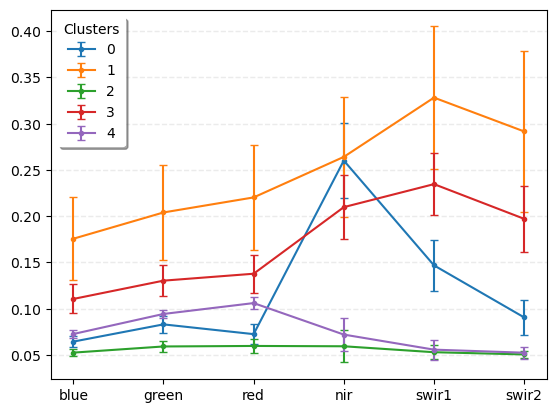

In [97]:
median.plot(yerr=std, marker=".", capsize=3, legend=False)
plt.legend(framealpha=1, title="Clusters", shadow=True, edgecolor="w")
plt.grid(axis="y", linestyle="--", linewidth=1, alpha=0.25)

<Axes: >

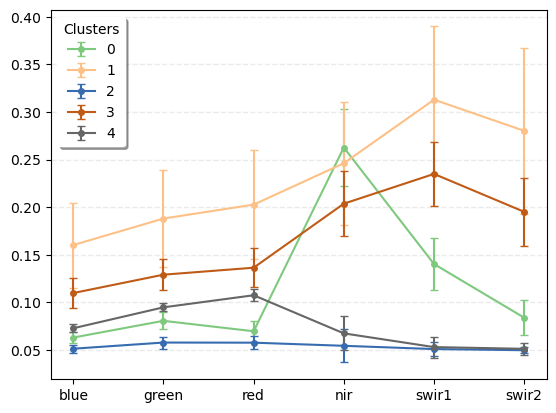

In [108]:
def plot_cluster_spectrum(scene, clusters, bands=None, ax=None, cmap=None, **kwargs):
    if bands is None:
        bands = list(scene)
    if ax is None:
        ax = plt.gca()
    features = _scene_to_dataframe(scene, bands=bands).assign(**{clusters.name: clusters.values.ravel()})
    labels = features[clusters.name].unique()
    if cmap is None:
        cmap = plt.get_cmap("Accent", labels.size)
    elif isinstance(cmap, str):
        cmap = plt.get_cmap(cmap, labels.size)    
    median = features.groupby(clusters.name)[bands].median().T
    std = features.groupby(clusters.name)[bands].std().T
    plot_args = dict(marker="o", markersize=4, capsize=3)
    plot_args.update(kwargs)
    median.plot(ax=ax, yerr=std, cmap=cmap, legend=False, **plot_args)
    ax.legend(framealpha=1, title="Clusters", shadow=True, edgecolor="w")
    ax.grid(axis="y", linestyle="--", linewidth=1, alpha=0.25)
    return ax

plot_cluster_spectrum(scene, clusters)

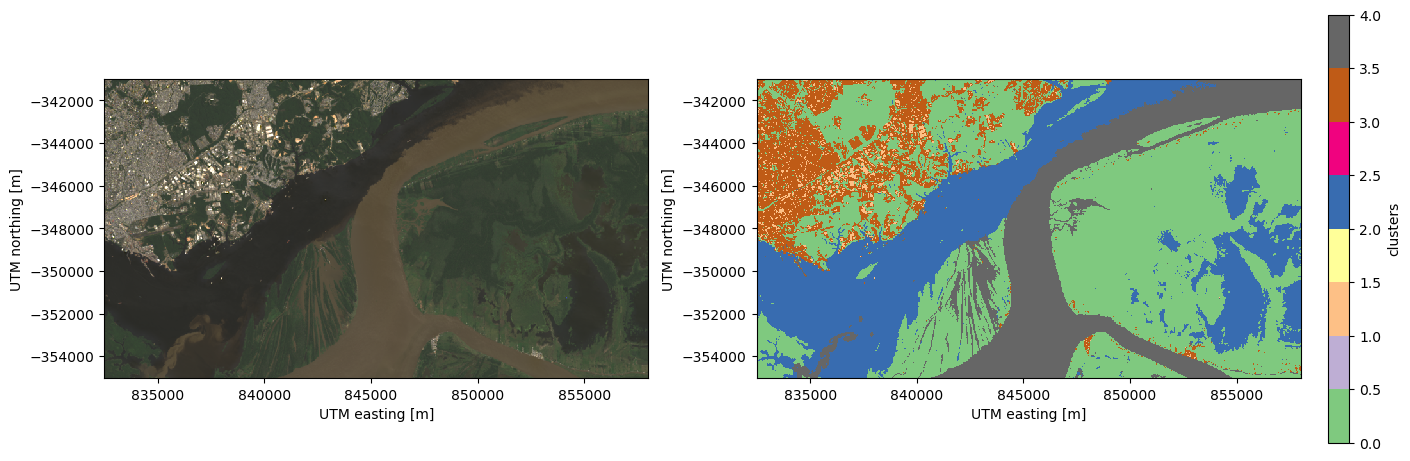

In [101]:
# Make the composite
rgb = xls.composite(scene, rescale_to=(0, 0.3))
# Adjust the L1 colors to make it nicer and get rid of the blue glare
# rgb = xls.adjust_l1_colors(rgb)
# Plot the RGB and thermal separately
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), layout="constrained")
rgb.plot.imshow(ax=ax1)
clusters.plot.imshow(cmap="Accent", ax=ax2)
ax1.set_aspect("equal")
ax2.set_aspect("equal")
plt.show()

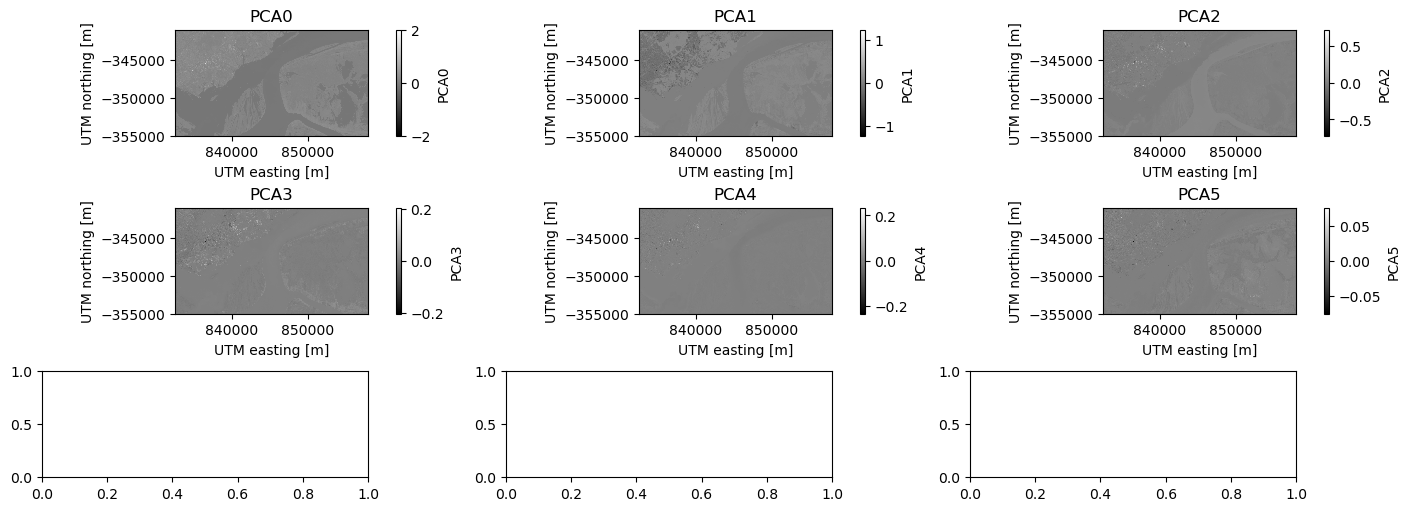

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(14, 5), layout="constrained")
for i, ax in zip(scene_pca, axes.ravel()):
    scene_pca[i].plot.imshow(ax=ax, cmap="gray")
    ax.set_aspect("equal")
    ax.set_title(i)

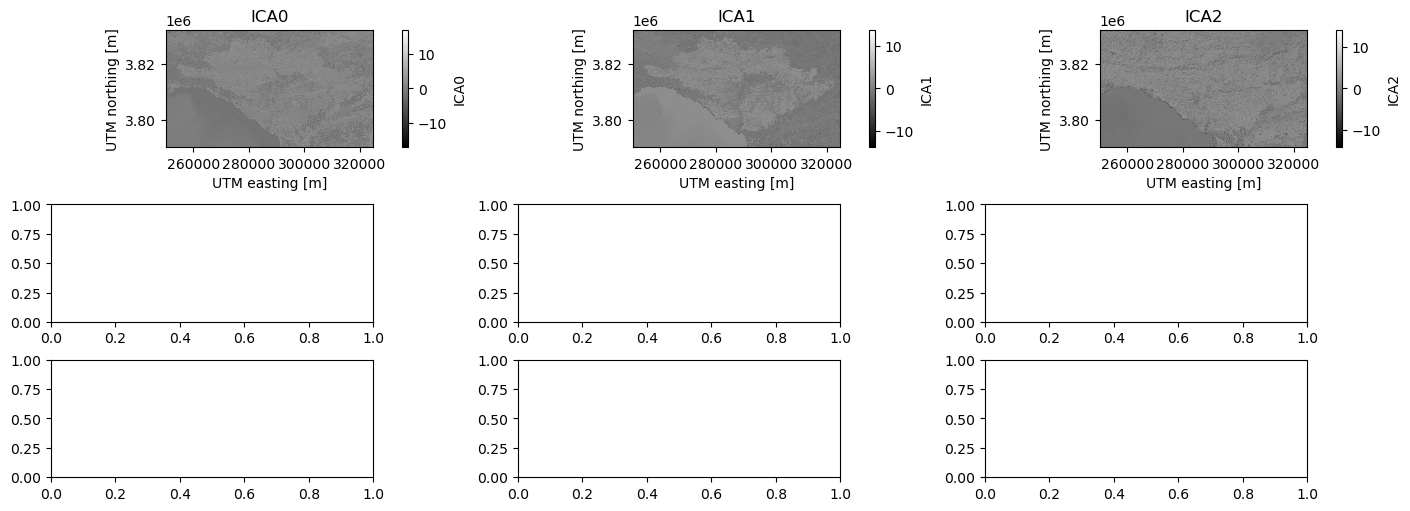

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(14, 5), layout="constrained")
for i, ax in zip(scene_ica, axes.ravel()):
    scene_ica[i].plot.imshow(ax=ax, cmap="gray")
    ax.set_aspect("equal")
    ax.set_title(i)